# Annual Cycle of Contributions

```{glue:figure} intra_annual_components
:scale: 50%
:align: right
```

The plot we'll make in this notebook is based on the figures in {cite:t}`mcinnes_extreme_2022`, which provides a nice summary on extreme sea levels in the pacific. The style of calculation and plot was first used in {cite:t}`merrifield_annual_2007`. In the Hawaiian Islands, most of the high water events are largely dominated by tides (aka "king tides" that occur in summer and winter), but these can be exacerbated by short term and seasonal contributions. To run this notebook, you will need to have already created a dataframe of non-tidal residuals. See the [components notebook](notebooks/components.ipynb) for more details on this. 

In [2]:
print('Importing libraries')
%run setup.ipynb
print('Importing plotting rules and functions')
import plotting_functions
print('Importing time series functions')
from tseries_functions import *
from tide_functions import calculate_ntr

Importing libraries
Successfully imported custom functions
Using custom paths from config_env.py
Data directory: /Users/jfiedler/Documents/SL_Hawaii_data/data
Output directory: /Users/jfiedler/Library/CloudStorage/GoogleDrive-jfiedler@hawaii.edu/Shared drives/PI Indicators 2025/SL Indicators/Hawaii_Region_Output
Importing plotting rules and functions
Importing time series functions


Next we'll open up our previous processes non-tidal residuals data. If you have not calculated this, first run the [components notebook](notebooks/components.ipynb).

In [3]:
ds = xr.open_dataset(data_dir / 'rsl_hawaii_noaa.nc')

# change all the station_ids to integers
ds['station_id'] = ds['station_id'].astype(int)


# get the ntr for each station
calculate_ntr(ds)

Already processed 28 files:
[1612480, 1617760, 1612340, 1617433, 1617433, 1612340, 1611400, 1617760, 1611400, 1615680, 1611400, 1612480, 1617760, 1612480, 1615680, 1619910, 1619910, 1612340, 1615680, 1615680, 1619910, 1617760, 1619910, 1617433, 1611400, 1617433, 1612480, 1612340]


Open it up and take a look.

In [4]:
# load ntr data
station_ids = ds['station_id'].values

station_id = station_ids[5]
print('Doing station', station_id)
station_name = ds.station_name.sel(station_id=station_id).item()
print('Station name:', station_name)
mhhw = ds.MHHW.sel(station_id=station_id).item()
msl = ds.MSL.sel(station_id=station_id).item()
mllw = ds.MLLW.sel(station_id=station_id).item()
ntrpath = f'ntr_data/ntr_{station_id}.csv'


ntr_data = pd.read_csv(Path(data_dir / ntrpath), parse_dates=['time'])

#inspect it, does it look sane?
ntr_data

Doing station 1612340
Station name: Honolulu


,time,ntr,ntr_noASA,sea_level,sea_level_detrended,trend,tide,nodal,ntr_withNodal,seasonal_cycle
0,1914-01-01 10:00:00,0.137569,0.126063,1.311,-0.014628,1.325628,-0.152198,0.007708,0.129862,-0.013880
1,1914-01-01 11:00:00,0.142889,0.131368,1.341,0.015372,1.325628,-0.127518,0.003320,0.139569,-0.013895
2,1914-01-01 12:00:00,0.117638,0.106101,1.372,0.046371,1.325629,-0.071267,-0.000583,0.118221,-0.013911
3,1914-01-01 13:00:00,0.127625,0.116073,1.463,0.137371,1.325629,0.009747,-0.003526,0.131151,-0.013926
4,1914-01-01 14:00:00,0.096769,0.085202,1.524,0.198371,1.325629,0.101602,-0.005915,0.102684,-0.013941
...,...,...,...,...,...,...,...,...,...,...
972994,2024-12-30 20:00:00,0.048630,0.038610,1.352,-0.095376,1.447376,-0.144006,-0.011927,0.060556,-0.012394
972995,2024-12-30 21:00:00,0.030172,0.020137,1.285,-0.162377,1.447377,-0.192549,-0.002070,0.032242,-0.012410
972996,2024-12-30 22:00:00,0.025105,0.015053,1.272,-0.175377,1.447377,-0.200481,0.009100,0.016004,-0.012425
972997,2024-12-30 23:00:00,0.028791,0.018724,1.298,-0.149377,1.447377,-0.178168,0.020459,0.008332,-0.012441


Now we'll resample it into daily maxima. 

In [5]:
# make a daily_max dataset
daily_max = ds.resample(time='1D').max()
daily_max_df = daily_max.sel(station_id=station_id).to_dataframe()

In [6]:
def filter_ntr(ntr_data):

    rec_length = (ntr_data['time'].max() - ntr_data['time'].min()).days
    
    
    ntr_decadal, ntr_highFreq = butterworth_lowpass(ntr_data['ntr'], time_diffs, 1/decadal, order=3) 
   
    #interannual
    ntr_interannual, ntr_highFreq = butterworth_lowpass(ntr_highFreq, time_diffs, 1/annual, order=3)

    # intraannual
    ntr_subannual, ntr_highFreq = butterworth_lowpass(ntr_highFreq, time_diffs, 1/monthly, order=5)

    ntr_monthly, ntr_highFreq = butterworth_lowpass(ntr_highFreq, time_diffs, 1/weekly, order=5)

    # Remove high frequencies (weekly to hourly)
    # ntr_weekly is timescales longer than 7 days but less than 1 month
    ntr_weekly, ntr_highFreq = butterworth_lowpass(ntr_highFreq, time_diffs, 1/daily, order=5)

    rank_tide = ntr_data['tide'].rank(method='first', ascending=False)

    # make dataframe of filtered data
    ntr_filtered = pd.DataFrame({'time': ntr_data['time'], 
                             'ntr': ntr_data['ntr'], 
                             'sea_level': ntr_data['sea_level'],
                             'sea_level_detrended': ntr_data['sea_level_detrended'],
                             'tide': ntr_data['tide'],
                             'Trend': ntr_data['trend'],
                            #  'Interdecadal': ntr_interdecadal, 
                             'Decadal': ntr_decadal, 
                             'Interannual': ntr_interannual, 
                             'Seasonal': ntr_data['seasonal_cycle'], 
                             'Subannual': ntr_subannual, 
                             'Monthly': ntr_monthly,
                             'Weekly': ntr_weekly, 
                             'Storms & HF': ntr_highFreq,
                             'Rank Tide': rank_tide } )
                        #    'NTR Trend': ntr_trend_series['ntr']
    

    component_names = list(ntr_filtered.columns) 
    component_names.remove('time')
    component_names.remove('ntr')
    component_names.remove('sea_level')
    component_names.remove('sea_level_detrended')
    component_names.remove('Rank Tide')

    # add trend back into ntr
    # ntr_filtered['ntr'] = ntr_filtered['ntr'] + ntr_filtered['NTR Trend']
    
    return ntr_filtered, component_names


And we'll set our timescale boundaries.

In [7]:
time_diffs = np.diff(ntr_data['time']).astype('timedelta64[h]').astype(int)

# Define timescales (in days)
annual = 365.25
biannual = 365.25*2
semiannual = 365.25/2
qtrannual = 365.25/4
daily = 7
weekly = 365.25/12
monthly = 3*365.25/12
decadal = 7*365.25

ntr_filtered, component_names = filter_ntr(ntr_data)

Filled 1 % of data with noise (std = 0.0645).


Let's also only look at 1993 to present.

In [8]:
# truncate ntr_filtered to 1993 to present
ntr_filtered = ntr_filtered.loc[ntr_filtered['time'] >= '1993-01-01']


In [21]:
# get daily maximum ntr_filtered
ntr_filtered_daily_max = ntr_filtered.groupby(ntr_filtered['time'].dt.date).max()

### Bootstrap your confidence!

Next we'll establish a routine to create error bounds for our total annual climatology of high water. This will be done via the bootstrap method, resampling our data to determine where the 95th percentile could be.

In [9]:
def bootstrap_percentile(data, percentile=95, n_bootstrap=1000, ci=0.95):
    """
    Calculate the confidence interval for a given percentile using bootstrapping.

    Parameters:
        data (array-like): The data to calculate the percentile for.
        percentile (float): The percentile to calculate (default is 95).
        n_bootstrap (int): Number of bootstrap resamples (default is 1000).
        ci (float): Confidence level for the interval (default is 0.95).

    Returns:
        tuple: (percentile_value, lower_bound, upper_bound)
    """
    bootstrapped_percentiles = []
    for _ in range(n_bootstrap):
        resample = np.random.choice(data, size=len(data), replace=True)
        bootstrapped_percentiles.append(np.percentile(resample, percentile))
    
    # Calculate the confidence interval bounds
    lower_bound = np.percentile(bootstrapped_percentiles, (1 - ci) / 2 * 100)
    upper_bound = np.percentile(bootstrapped_percentiles, (1 + ci) / 2 * 100)
    return np.percentile(data, percentile), lower_bound, upper_bound

In [10]:
def calculate_percentiles_with_ci(group, columns, percentile=99, n_bootstrap=1000, ci=0.95):
    """
    Calculate the percentile and confidence intervals for multiple columns using bootstrapping.

    Parameters:
        group (DataFrame): The group of data to calculate the statistics for.
        columns (list): List of column names to calculate the statistics for.
        percentile (float): The percentile to calculate (default is 99).
        n_bootstrap (int): Number of bootstrap resamples (default is 1000).
        ci (float): Confidence level for the interval (default is 0.95).

    Returns:
        pd.Series: A series containing the calculated percentiles and confidence intervals for each column.
    """
    results = {}
    for col in columns:
        data = group[col].dropna()
        if len(data) > 0:
            p, lower, upper = bootstrap_percentile(data, percentile=percentile, n_bootstrap=n_bootstrap, ci=ci)
            results[f'{col}_{percentile}th'] = p
            results[f'{col}_ci_lower'] = lower
            results[f'{col}_ci_upper'] = upper
        else:
            results[f'{col}_{percentile}th'] = np.nan
            results[f'{col}_ci_lower'] = np.nan
            results[f'{col}_ci_upper'] = np.nan
    return pd.Series(results)

Next we'll lump all our short-term components together (everything up to 1 year).

In [22]:
short_term_components = ['Storms & HF', 'Weekly', 'Monthly', 'Subannual']
ntr_filtered_daily_max['short_term'] = ntr_filtered_daily_max[short_term_components].sum(axis=1)
ntr_filtered_daily_max['doy'] = ntr_filtered_daily_max['time'].dt.dayofyear

total_components = ['short_term','tide','Seasonal']
ntr_filtered_daily_max['total'] = ntr_filtered_daily_max[total_components].sum(axis=1)

Then we'll find the 98th percentile for each day (of the year) for our short-term components, the tide, and the total.

In [33]:
# List of columns to calculate percentiles and confidence intervals for
columns_to_calculate = ['short_term', 'tide','total']

# Group by 'doy' and do some bootstrappin'
short_term_and_tide_daily98 = ntr_filtered_daily_max.groupby('doy', group_keys=False).apply(
    lambda group: calculate_percentiles_with_ci(
        group[columns_to_calculate],  # Operate only on the selected columns
        columns=columns_to_calculate,
        percentile=98,
        n_bootstrap=1000,
        ci=0.95
    ),
    include_groups=False
).reset_index()

For general plotting prettiness, we'll smooth our calculated percentiles with a 30 day rolling mean filter. 

In [34]:
def smooth_n_day(series,window=30):
    return series.rolling(window=window, center=True, min_periods=2).mean()


# daily_max_smooth = daily_max.copy()
# ntr_filtered_daily_smooth = ntr_filtered_daily.copy()
# Apply rolling mean to all relevant columns in one step
columns_to_smooth = [col for col in short_term_and_tide_daily98.columns if col.startswith(tuple(columns_to_calculate))]
# daily_max_smooth[columns_to_smooth] = daily_max_smooth[columns_to_smooth].rolling(window=30, center=True, min_periods=2).mean()
# columns_to_smooth = ['sea_level', 'tide', 'short_term', 'short_term_upper', 'short_term_lower']


# Godin-style smoothing:
short_term_and_tide_daily98[columns_to_smooth] = smooth_n_day(short_term_and_tide_daily98[columns_to_smooth], window=30)
short_term_and_tide_daily98[columns_to_smooth] = smooth_n_day(short_term_and_tide_daily98[columns_to_smooth], window=31)
short_term_and_tide_daily98[columns_to_smooth] = smooth_n_day(short_term_and_tide_daily98[columns_to_smooth], window=32)

In [ ]:
# get Seasonal year-long timeseries
seasonal_daily = ntr_filtered_daily_max.groupby('doy').mean()

## Plot
Finally, we'll plot it up.

In [36]:
total_daily = short_term_and_tide_daily98
total_daily

,doy,short_term_98th,short_term_ci_lower,short_term_ci_upper,tide_98th,tide_ci_lower,tide_ci_upper,total_98th,total_ci_lower,total_ci_upper
0,1,0.107248,0.082329,0.117841,0.471711,0.439868,0.482121,0.515174,0.473382,0.537703
1,2,0.107254,0.082308,0.117829,0.471417,0.439558,0.481802,0.514863,0.472995,0.537332
2,3,0.107254,0.082281,0.117804,0.471104,0.439230,0.481464,0.514524,0.472573,0.536926
3,4,0.107247,0.082247,0.117769,0.470778,0.438890,0.481112,0.514164,0.472120,0.536495
4,5,0.107234,0.082205,0.117725,0.470442,0.438538,0.480749,0.513788,0.471639,0.536042
...,...,...,...,...,...,...,...,...,...,...
361,362,0.129124,0.088180,0.145863,0.487778,0.454464,0.494605,0.565443,0.502016,0.592417
362,363,0.129105,0.088215,0.145892,0.487750,0.454399,0.494549,0.565387,0.501801,0.592301
363,364,0.129084,0.088250,0.145919,0.487707,0.454321,0.494481,0.565322,0.501580,0.592172
364,365,0.129064,0.088283,0.145947,0.487659,0.454237,0.494408,0.565256,0.501360,0.592045


And now, we plot.

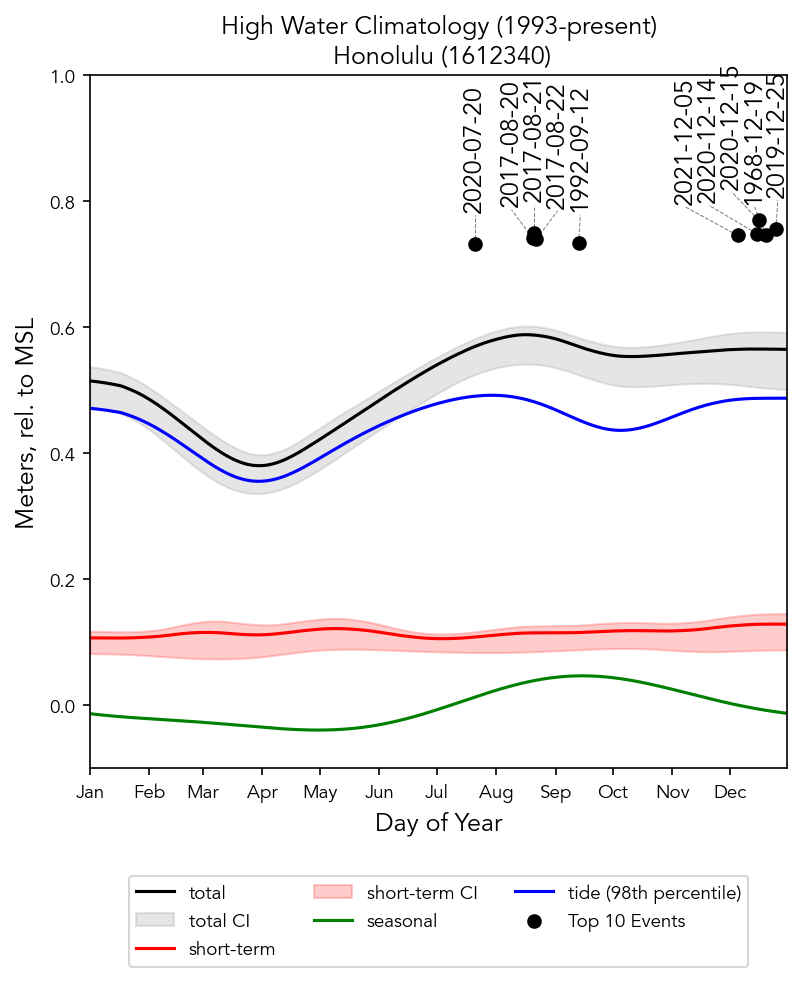

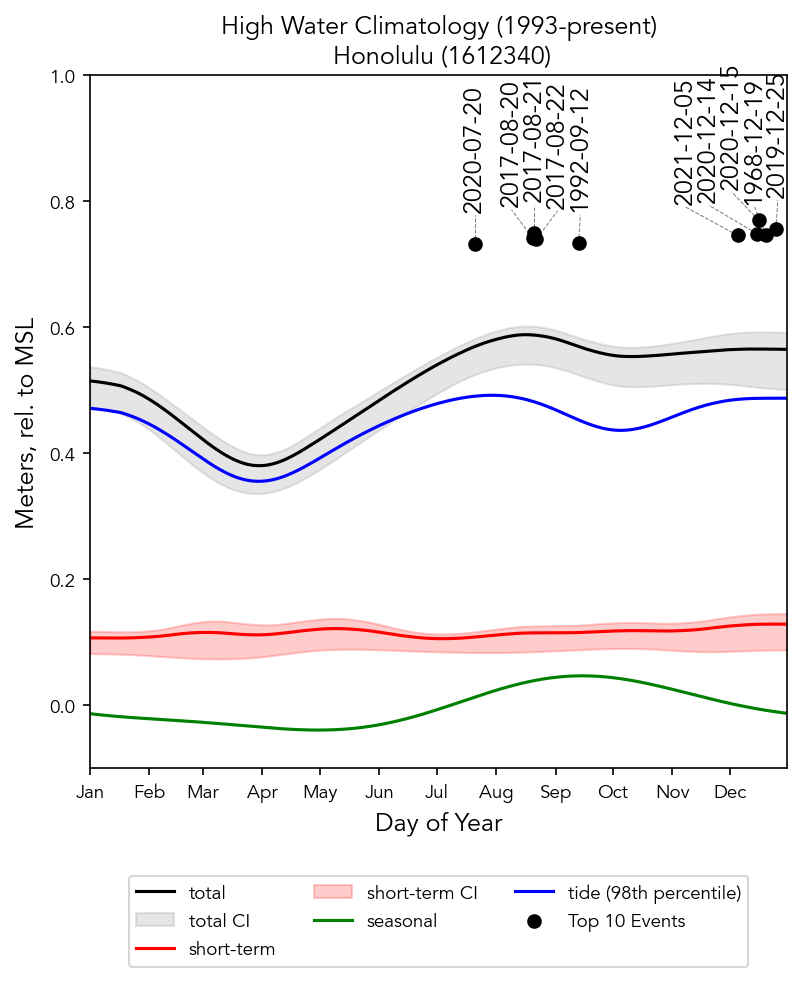

In [37]:
fig, ax = plt.subplots(figsize=(6,6))

# Plot ntr+tide
sns.lineplot(data=short_term_and_tide_daily98, x='doy', y='total_98th', ax=ax, label='total', color='black')
ax.fill_between(
    short_term_and_tide_daily98['doy'],
    short_term_and_tide_daily98['total_ci_upper'],
    short_term_and_tide_daily98['total_ci_lower'],
    color='gray',
    alpha=0.2,
    label='total CI'
)

# Plot short_term
sns.lineplot(data=short_term_and_tide_daily98, x='doy', y='short_term_98th', ax=ax, label='short-term', color='red')
ax.fill_between(
    short_term_and_tide_daily98['doy'],
    short_term_and_tide_daily98['short_term_ci_upper'],
    short_term_and_tide_daily98['short_term_ci_lower'],
    color='red',
    alpha=0.2,
    label='short-term CI'
)


sns.lineplot(data=seasonal_daily, x='doy', y='Seasonal', ax=ax, label='seasonal', color='green')
sns.lineplot(data=short_term_and_tide_daily98, x='doy', y='tide_98th', ax=ax, label='tide (98th percentile)', color='blue')

# sns.lineplot(tp98, ax=ax, label='tide + trend 98th percentile', color='orange')
ax.set_title(f'High water climatology at {station_name} ({station_id})')
ax.set_ylabel('meters')
ax.set_xlabel('Day of Year')

# set xlim to 1-365
ax.set_xlim(1, 365)

# replace numbers with month names
month_starts = [1, 32, 60, 91, 121, 152, 182, 213, 244, 274, 305, 335]
month_names = ['Jan', 'Feb', 'Mar', 'Apr', 'May', 'Jun', 'Jul', 'Aug', 'Sep', 'Oct', 'Nov', 'Dec']
ax.set_xticks(month_starts)
ax.set_xticklabels(month_names)

# now add top 10 events at station
top_events = daily_max_df.nlargest(10, 'sea_level')
msl = ds.MSL.sel(station_id=station_id).item()

top_events['doy'] = top_events.index.dayofyear
top_events.sort_values('doy', inplace=True)

ax.scatter(top_events['doy'], top_events['sea_level']-msl, color='black', zorder=5, label='Top 10 Events')

xmin, xmax    = 1, 360    # allowed label domain
min_cluster   = 12        # points within ≤ this many days belong to same cluster
min_sep       = 12        # minimum horizontal gap (days) between labels in ANY cluster
pad           = 0         # extra padding from domain edges

# --- build clusters (sorted by DOY) ---
clusters = []
cluster = []
for x in top_events['doy'].sort_values():
    if not cluster or (x - cluster[-1] <= min_cluster):
        cluster.append(x)
    else:
        clusters.append(cluster)
        cluster = [x]
if cluster:
    clusters.append(cluster)

# --- place clusters sequentially with guaranteed spacing and bounds ---
adjusted_x = []
prev_end = xmin - 1e9  # effectively -inf

for xs in clusters:
    xs = np.asarray(xs, float)
    n  = len(xs)

    if n == 1:
        # single label: place at its x, but not before prev_end+min_sep or beyond xmax
        s = max(xs[0], prev_end + min_sep)
        s = np.clip(s, xmin + pad, xmax - pad)
        adjusted_x.append(s)
        prev_end = s
        continue

    W  = (n - 1) * min_sep                     # width required inside the cluster
    s0 = xs.mean() - W / 2.0                   # center cluster on its mean
    s_min = max(xmin + pad, prev_end + min_sep)          # must start after previous end
    s_max = xmax - pad - W                                 # must end before domain edge
    s = np.clip(s0, s_min, s_max)

    adj = s + np.arange(n) * min_sep
    adjusted_x.extend(adj)
    prev_end = adj[-1]

# assign back in the same sorted order
top_events = top_events.sort_values('doy').copy()
top_events['x_label'] = adjusted_x

for dt, x, xlab, y in zip(top_events.index, top_events["doy"], top_events["x_label"], top_events['sea_level']-msl):
    # label text
    ax.text(xlab, y + 0.05, f"{dt:%Y-%m-%d}",
            rotation=90, ha="center", va="bottom",
            color="black", clip_on=False)
    # leader line
    ax.plot([x, xlab], [y, y + 0.045],
            color="0.5", lw=0.5, zorder=4, linestyle="--")

ax.set_title(f'High Water Climatology (1993-present)\n {station_name} ({station_id})')
ax.set_ylabel('Meters, rel. to MSL')
ax.set_xlim(1, 365)
ax.set_ylim(-0.1, 1)
plt.legend(loc='lower center', bbox_to_anchor=(0.5, -0.3), ncol=3)
plt.show()


# save figure
fig.savefig(output_dir / f'intra_annual_components_{station_id}.png', dpi=150, bbox_inches='tight')
#glue the figure
glue('intra_annual_components', fig)

```{glue:figure} intra_annual_components
:name: "intra_annual_components"

High water climatology at the Honolulu tide gauge from 1993 to present. The top 10 events (using the whole record) are also shown. Short-term climatology includes non-tidal residuals occuring at timescales shorter than 1 year. The seasonal cycle is the summation of the solar annual (SA) and solar semi-annual (SSA) tidal cycle. Shaded areas represent the 95% confidence intervals for the total and short-term climatologies. 
```